<a href="https://colab.research.google.com/github/nitsansoffair/IK/blob/main/IK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mount.

In [1]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Extraction.
[Dataset](https://drive.google.com/file/d/1MgMGTq882XyVve4dE9fQpPsY2WYMJFv9/view?usp=sharing).

In [132]:
import zipfile

from pathlib import Path

# Extract the ZIP file

zip_path = "/content/drive/MyDrive/PhD/BGU/BigData/Project/IK.zip"
extract_path = "/content/audios"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Define paths for video folders
positive_path = Path(extract_path) / "positive"
negative_path = Path(extract_path) / "negative"

Dataset.

In [133]:
import torch
import librosa
import numpy as np

from torch.utils.data import Dataset, DataLoader

class AudioDataset(Dataset):
    def __init__(self, audio_dir, label, sample_rate=16_000, max_duration=20):
        self.audio_dir = Path(audio_dir)
        self.label = label
        self.audio_files = list(self.audio_dir.glob("*.mp3"))

        self.sample_rate = sample_rate
        self.max_duration = max_duration  # in seconds

    def __len__(self):
        return len(self.audio_files)

    def __getitem__(self, idx):
        audio_path = str(self.audio_files[idx])
        y, sr = librosa.load(audio_path, sr=self.sample_rate, duration=self.max_duration)

        # Ensure consistent length (pad or truncate)
        if len(y) < self.sample_rate * self.max_duration:
            y = np.pad(y, (0, self.sample_rate * self.max_duration - len(y)), mode='constant')
        else:
            y = y[:self.sample_rate * self.max_duration]

        # Convert audio waveform to tensor
        audio_tensor = torch.tensor(y, dtype=torch.float32)

        # If your model expects 2D input (batch_size, input_length), ensure the input shape is correct
        # Reshape to shape (1, input_length) for a single sample (e.g., [batch_size, 16000])
        audio_tensor = audio_tensor.unsqueeze(0)  # Add batch dimension

        return audio_tensor, self.label

Split.

In [134]:
from torch.utils.data import random_split, ConcatDataset

# Prepare datasets
positive_dataset = AudioDataset(positive_path, 0)
negative_dataset = AudioDataset(negative_path, 1)

# Combine datasets
full_dataset = ConcatDataset([positive_dataset, negative_dataset])

# Split dataset into train and test
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size

train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# DataLoader with a custom collate function
def collate_fn(batch):
    audios, labels = zip(*batch)

    # Pad all audio features to have the same shape (consistent MFCC length)
    max_len = max(audio.shape[1] for audio in audios)
    padded_audios = [torch.nn.functional.pad(audio, (0, max_len - audio.shape[1])) for audio in audios]

    audios_tensor = torch.stack(padded_audios)
    labels_tensor = torch.tensor(labels)

    return audios_tensor, labels_tensor

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False, collate_fn=collate_fn)

Model.

In [135]:
import torch.nn as nn

from transformers import Wav2Vec2Model, Wav2Vec2Config

# Define the custom model class
class Wav2Vec2Classifier(nn.Module):
    def __init__(self, num_classes=2):
        super(Wav2Vec2Classifier, self).__init__()

        # Load Wav2Vec2Model with no pretrained weights (use the base configuration)
        config = Wav2Vec2Config(hidden_size=768)  # You can change hidden_size based on your needs
        self.wav2vec2 = Wav2Vec2Model(config)

        # The size of the encoder's hidden states
        encoder_output_dim = config.hidden_size

        # Define the classifier (fully connected layer)
        self.fc = nn.Linear(encoder_output_dim, num_classes)

    def forward(self, input_values):
        # Forward pass through Wav2Vec2 model (feature extraction)
        outputs = self.wav2vec2(input_values)
        hidden_states = outputs.last_hidden_state

        # Take the mean of the hidden states across time steps (for audio classification)
        pooled_output = hidden_states.mean(dim=1)

        # Pass through the fully connected layer for classification
        logits = self.fc(pooled_output)

        return logits

Train blocks.

In [136]:
# Instantiate and test the model
model = Wav2Vec2Classifier(num_classes=2).cuda()

# Loss and optimizer
criterion = nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=.0001)

Train loop.

In [137]:
import torch.optim as optim
import torch.nn as nn

# Assume the model, criterion, optimizer, train_loader, and other variables are already defined

def train_model(model, train_loader, criterion, optimizer, n_epochs, report_freq):
    for epoch in range(n_epochs):
        model.train()  # Set the model to training mode
        loss_epoch = 0  # Initialize loss for the current epoch

        for audios, labels in train_loader:
            # Ensure audios and labels are on the correct device (GPU or CPU)
            audios, labels = audios.cuda(), labels.cuda()

            audios = audios.squeeze(1)

            # Forward pass: Get model predictions
            outputs = model(audios)

            # Compute loss
            loss = criterion(outputs, labels)

            # Backward pass and optimization step
            optimizer.zero_grad()  # Zero the gradients
            loss.backward()  # Backpropagate the loss
            optimizer.step()  # Perform the optimization step

            # Accumulate loss for the epoch
            loss_epoch += loss.item()

        # Print loss at specified intervals
        if epoch % report_freq == 0:
            print(f"Epoch {epoch + 1}, Loss: {loss_epoch:.2f}")

# Example usage of train_model function:
train_model(model.cuda(), train_loader, criterion, optimizer, n_epochs=3, report_freq=1)

Epoch 1, Loss: 21.90
Epoch 2, Loss: 5.24
Epoch 3, Loss: 4.14


Evaluation.

In [141]:
# Evaluation
def evaluate(model, test_loader):
    model.eval()  # Set the model to evaluation mode

    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient computation for evaluation
        for audios, labels in test_loader:
            audios, labels = audios.cuda(), labels.cuda()

            audios = audios.squeeze(1)

            outputs = model(audios)  # Forward pass with audio data

            _, predicted = torch.max(outputs.data, 1)  # Get the index of the max log-probability

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f"Accuracy: {100 * correct / total:.2f}%")

# Call the evaluation function
evaluate(model, test_loader)

Accuracy: 66.67%


Test.

In [142]:
index = 0

In [143]:
import torchaudio
import IPython.display as ipd
import matplotlib.pyplot as plt

# Display a test example
def show_test_example(model, test_loader):
    model.eval()

    audios, labels = next(iter(test_loader))
    audios = audios.squeeze(1)

    audio = audios[index, :].unsqueeze(0).cuda()

    print(labels)
    # audio = audios[0].cpu().numpy()  # Get the first audio sample
    label = labels[index].item()

    # Get the model's prediction
    with torch.no_grad():
        output = model(audio)
        predicted_label = torch.argmax(output, dim=1).item()

    # Convert the audio tensor to a playable format
    waveform = audio  # Assuming mono audio for simplicity

    waveform = waveform.cpu()

    # Display the audio with a listening bar
    ipd.display(ipd.Audio(waveform, rate=16_000))  # Assuming a sample rate of 16 kHz

    # Print the ground truth and prediction
    print(f"Ground Truth: {'Positive' if label == 0 else 'Negative'}, "
          f"Prediction: {'Negative' if predicted_label == 1 else 'Positive'}")

# Call the function to test
show_test_example(model, test_loader)

tensor([0, 0])


Ground Truth: Positive, Prediction: Negative


Visualization.

Videos.

In [3]:
import zipfile
import os
import cv2
import torch
import torchaudio
import librosa
import numpy as np

from pathlib import Path

# Extract the ZIP file
zip_path = "/content/drive/MyDrive/PhD/BGU/BigData/Project/Video/IK.zip"
extract_path = "/content/videos"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Define paths for video folders
positive_path = Path(extract_path) / "idialists"
negative_path = Path(extract_path) / "politicians"

/usr/local/lib/python3.11/dist-packages/speechbrain/utils/checkpoints.py:145: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(path, map_location=device), strict=Fal

Identify speaker.

In [79]:
import os
import cv2
import numpy as np
import tensorflow as tf

from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Paths to video folders
video_path = "/content/videos"
categories = ["idialists", "politicians"]

img_size = 128  # Resize images to 128x128
frames_per_video = 5  # Number of frames to extract per video

# Total classes.
num_classes = 26

def extract_frames(video_path, label):
    """Extracts frames from a video file."""
    cap = cv2.VideoCapture(video_path)
    frames = []

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_interval = max(1, total_frames // frames_per_video)

    for i in range(frames_per_video):
        cap.set(cv2.CAP_PROP_POS_FRAMES, i * frame_interval)
        ret, frame = cap.read()

        if ret:
            frame = cv2.resize(frame, (img_size, img_size))
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append((frame, label))

    cap.release()
    return frames

# Load dataset
images, labels = [], []
label_map = {}
label_idx = 0

for category in categories:
    folder_path = os.path.join(video_path, category)
    for filename in os.listdir(folder_path):
        if filename.endswith(".mp4"):
            speaker = filename.split(".")[0]  # Get speaker name from filename
            if speaker not in label_map:
                label_map[speaker] = label_idx
                label_idx += 1

            video_frames = extract_frames(os.path.join(folder_path, filename), label_map[speaker])
            for frame, label in video_frames:
                images.append(frame)
                labels.append(label)

# Convert to NumPy arrays
images = np.array(images) / 255.0  # Normalize
labels = np.array(labels)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42, stratify=labels)

# One-hot encode the labels
y_train = to_categorical(y_train, num_classes=26)
y_test = to_categorical(y_test, num_classes=26)

In [80]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, img_size, num_classes=26):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)

        # Calculate the flattened size after convolutions
        final_size = img_size // (2 * 2 * 2)  # Three max pooling layers
        self.fc1 = nn.Linear(128 * final_size * final_size, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = torch.flatten(x, start_dim=1)  # Flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x  # No softmax, since CrossEntropyLoss applies it internally

In [115]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Define device (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to device
model = CNN(img_size=128, num_classes=26).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Convert NumPy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).permute(0, 3, 1, 2)  # Convert to (N, C, H, W)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)  # Ensure correct dtype

X_test_tensor = torch.tensor(X_test, dtype=torch.float32).permute(0, 3, 1, 2)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create PyTorch DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=26, shuffle=True)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=26, shuffle=False)

In [119]:
# Training loop
num_epochs = 15

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU if available

        optimizer.zero_grad()  # Clear gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        running_loss += loss.item()
        _, predicted = outputs.max(1)

        # Shape.
        predicted = predicted.unsqueeze(1)

        # Labels.
        labels = torch.tensor([[list(labels[i]).index(1)] for i in range(labels.shape[1])]).to(device)

        correct += (predicted == labels).sum().item()
        total += labels.shape[0]

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total

Validate.

In [121]:
# Validation
model.eval()  # Set model to evaluation mode

val_loss = 0.0
val_correct = 0
val_total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        val_loss += loss.item()
        _, predicted = outputs.max(1)

        # Shape.
        predicted = predicted.unsqueeze(1)

        # Labels.
        labels = torch.tensor([[list(labels[i]).index(1)] for i in range(labels.shape[1])]).to(device)

        val_correct += (predicted == labels).sum().item()
        val_total += labels.size(0)

val_loss /= len(test_loader)
val_acc = 100 * val_correct / val_total

print(f"Epoch [{epoch + 1}/{num_epochs}] - Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

Epoch [15/15] - Loss: 0.0376, Train Acc: 99.04% | Val Loss: 3.1959, Val Acc: 69.23%


Display test.

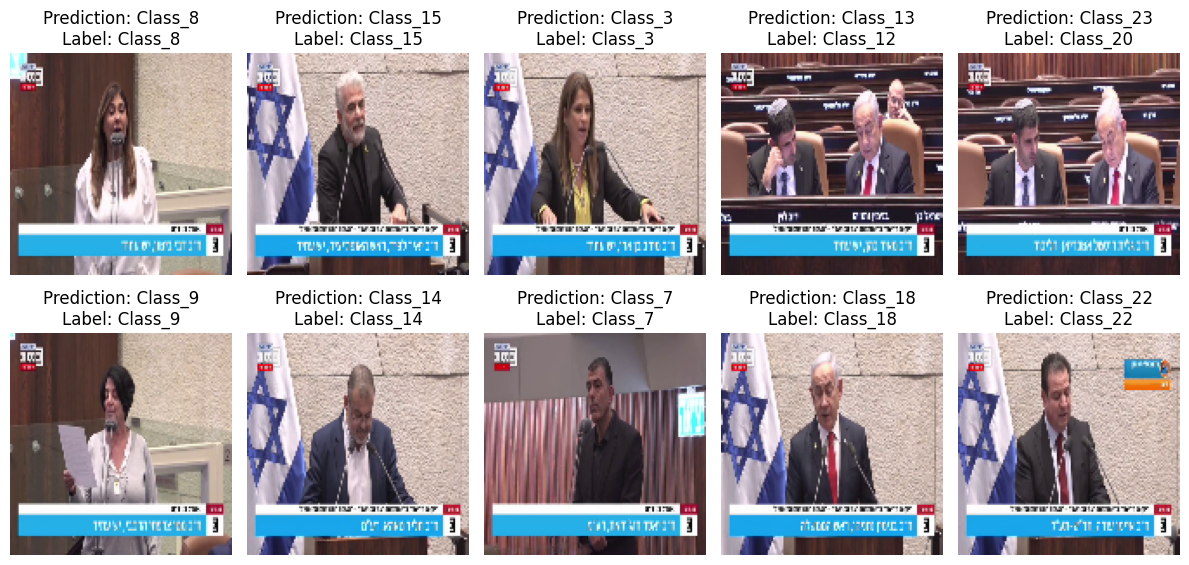

In [123]:
import matplotlib.pyplot as plt
import numpy as np

# Get a batch of test data
data_iter = iter(test_loader)
images, labels = next(data_iter)

# Move data to device
images, labels = images.to(device), labels.to(device)

# Get model predictions
model.eval()
with torch.no_grad():
    outputs = model(images)
    _, predicted = outputs.max(1)

# Class names (modify this according to your dataset)
class_names = {i: f"Class_{i}" for i in range(26)}  # Example: {0: "A", 1: "B", ..., 25: "Z"}

# Plot images with predictions
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
axes = axes.flatten()

for i in range(10):
    img = images[i].cpu().permute(1, 2, 0).numpy()  # Convert from (C, H, W) to (H, W, C)
    true_label = class_names[list(labels[i]).index(1)]
    pred_label = class_names[predicted[i].item()]

    axes[i].imshow(img)
    axes[i].set_title(f"Prediction: {pred_label}\nLabel: {true_label}")
    axes[i].axis("off")

plt.tight_layout()
plt.show()